In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.drop('Precipitacao', axis=1, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                              
2015-01-01        35.0        23.7        5.9              10.2   
2015-01-02        35.8        23.0       10.6              10.2   
2015-01-03        31.9        22.3        4.3               6.2   
2015-01-04        27.3        20.7        1.9               3.5   
2015-01-05        32.4        20.7        8.3               1.5   
...                ...         ...        ...               ...   
2018-04-26        31.0        20.8        8.9               0.5   
2018-04-27        31.7        22.9       10.5               0.5   
2018-04-28        31.3        21.5        9.5               0.5   
2018-04-29        28.9        22.7        2.5               0.5   
2018-04-30        28.9        21.9        2.5               0.5   

            Temp Comp Media  Umidade Relativa Media  Velocidade do Vento Media  
date                                           

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values
features = len(dataset.columns)

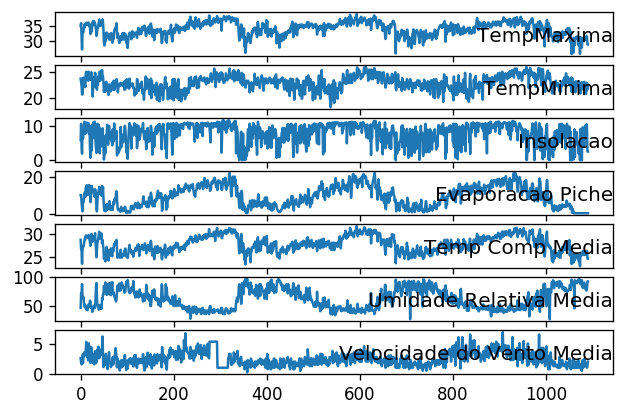

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,features)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,features)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,features)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,features)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
        
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nErrors')
    for i in range(0,len(y_hats_max)):
        error = abs(y_hats_max[i] - y_tests_max[i])
        print('{}/04/2018 = {}'.format(30-i,error))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    print('\nErrors')
    for i in range(0,len(y_hats_min)):
        error = abs(y_hats_min[i] - y_tests_min[i])
        print('{}/04/2018 = {}'.format(30-i,error))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7294 - mean_squared_error: 0.8551 - val_loss: 0.9329 - val_mean_squared_error: 1.4410
Epoch 2/1000
 - 1s - loss: 0.6023 - mean_squared_error: 0.6142 - val_loss: 0.8291 - val_mean_squared_error: 1.2991
Epoch 3/1000
 - 1s - loss: 0.5676 - mean_squared_error: 0.5537 - val_loss: 0.8768 - val_mean_squared_error: 1.4892
Epoch 4/1000
 - 1s - loss: 0.5478 - mean_squared_error: 0.5280 - val_loss: 0.9466 - val_mean_squared_error: 1.7183
Epoch 5/1000
 - 1s - loss: 0.5372 - mean_squared_error: 0.5085 - val_loss: 0.9696 - val_mean_squared_error: 1.7889
Epoch 6/1000
 - 1s - loss: 0.5299 - mean_squared_error: 0.4970 - val_loss: 1.0465 - val_mean_squared_error: 2.0447
Epoch 7/1000
 - 1s - loss: 0.5278 - mean_squared_error: 0.4966 - val_loss: 1.0086 - val_mean_squared_error: 1.8929
Epoch 8/1000
 - 1s - loss: 0.5254 - mean_squared_error: 0.4869 - val_loss: 1.1241 - val_mean_squared_error: 2.2201
Epoch 9/1000
 - 1s - loss: 0.5244 -

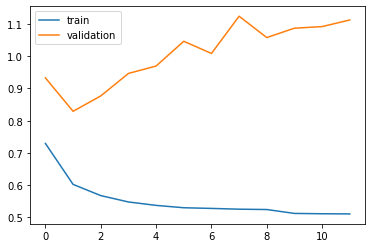


predict: [[31.80765894 22.729343  ]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8602 - mean_squared_error: 1.1421 - val_loss: 0.9026 - val_mean_squared_error: 0.8197
Epoch 2/1000
 - 1s - loss: 0.6952 - mean_squared_error: 0.7865 - val_loss: 0.7625 - val_mean_squared_error: 0.5906
Epoch 3/1000
 - 1s - loss: 0.6093 - mean_squared_error: 0.6437 - val_loss: 0.8461 - val_mean_squared_error: 0.7165
Epoch 4/1000
 - 1s - loss: 0.5735 - mean_squared_error: 0.5698 - val_loss: 0.8598 - val_mean_squared_error: 0.7396
Epoch 5/1000
 - 1s - loss: 0.5536 - mean_squared_error: 0.5341 - val_loss: 0.9685 - val_mean_squared_error: 0.9389
Epoch 6/1000
 - 1s - loss: 0.5458 - mean_squared_error: 0.5191 - val_loss: 1.0090 - val_mean_squared_error: 1.0274
Epoch 7/1000
 - 1s - loss: 0.5365 - mean_squared_error: 0.5068 - val_loss: 0.9796 - val_mean_squared_error: 0.9852
Epoch 8/1000
 - 1s - loss: 0.5267 - mean_squared_error: 0.4909 - val_loss: 0.9459 - va

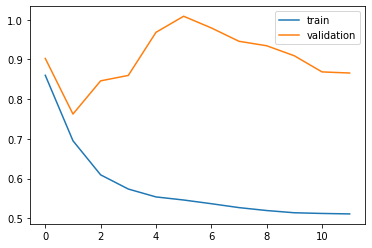


predict: [[32.14031143 22.62378828]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7531 - mean_squared_error: 0.8774 - val_loss: 0.2502 - val_mean_squared_error: 0.0766
Epoch 2/1000
 - 1s - loss: 0.6251 - mean_squared_error: 0.6325 - val_loss: 0.2426 - val_mean_squared_error: 0.1031
Epoch 3/1000
 - 1s - loss: 0.5728 - mean_squared_error: 0.5587 - val_loss: 0.3214 - val_mean_squared_error: 0.1228
Epoch 4/1000
 - 1s - loss: 0.5536 - mean_squared_error: 0.5272 - val_loss: 0.3026 - val_mean_squared_error: 0.1147
Epoch 5/1000
 - 1s - loss: 0.5438 - mean_squared_error: 0.5147 - val_loss: 0.3209 - val_mean_squared_error: 0.1202
Epoch 6/1000
 - 1s - loss: 0.5371 - mean_squared_error: 0.5034 - val_loss: 0.3392 - val_mean_squared_error: 0.1304
Epoch 7/1000
 - 1s - loss: 0.5288 - mean_squared_error: 0.4882 - val_loss: 0.4821 - val_mean_squared_error: 0.2566
Epoch 8/1000
 - 1s - loss: 0.5240 - mean_squared_error: 0.4824 - val_loss: 0.5111 - va

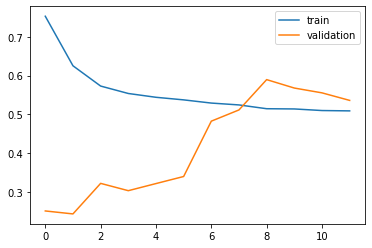


predict: [[32.10213327 22.78480063]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6983 - mean_squared_error: 0.7977 - val_loss: 1.0659 - val_mean_squared_error: 1.2087
Epoch 2/1000
 - 1s - loss: 0.6003 - mean_squared_error: 0.6174 - val_loss: 1.0493 - val_mean_squared_error: 1.1896
Epoch 3/1000
 - 1s - loss: 0.5749 - mean_squared_error: 0.5707 - val_loss: 1.1029 - val_mean_squared_error: 1.2948
Epoch 4/1000
 - 1s - loss: 0.5537 - mean_squared_error: 0.5352 - val_loss: 1.1441 - val_mean_squared_error: 1.3813
Epoch 5/1000
 - 1s - loss: 0.5466 - mean_squared_error: 0.5202 - val_loss: 1.1323 - val_mean_squared_error: 1.3577
Epoch 6/1000
 - 1s - loss: 0.5379 - mean_squared_error: 0.5065 - val_loss: 1.1477 - val_mean_squared_error: 1.3971
Epoch 7/1000
 - 1s - loss: 0.5302 - mean_squared_error: 0.4960 - val_loss: 1.1574 - val_mean_squared_error: 1.4104
Epoch 8/1000
 - 1s - loss: 0.5272 - mean_squared_error: 0.4891 - val_loss: 1.1314 - va

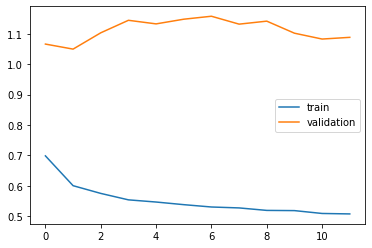


predict: [[31.95420864 22.44462941]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7383 - mean_squared_error: 0.8586 - val_loss: 1.0308 - val_mean_squared_error: 1.0997
Epoch 2/1000
 - 1s - loss: 0.6592 - mean_squared_error: 0.7074 - val_loss: 1.1592 - val_mean_squared_error: 1.3687
Epoch 3/1000
 - 1s - loss: 0.5843 - mean_squared_error: 0.5870 - val_loss: 1.0024 - val_mean_squared_error: 1.0370
Epoch 4/1000
 - 1s - loss: 0.5581 - mean_squared_error: 0.5317 - val_loss: 1.1201 - val_mean_squared_error: 1.2603
Epoch 5/1000
 - 1s - loss: 0.5412 - mean_squared_error: 0.5086 - val_loss: 1.1640 - val_mean_squared_error: 1.3572
Epoch 6/1000
 - 1s - loss: 0.5287 - mean_squared_error: 0.4875 - val_loss: 1.1772 - val_mean_squared_error: 1.3865
Epoch 7/1000
 - 1s - loss: 0.5202 - mean_squared_error: 0.4755 - val_loss: 1.0186 - val_mean_squared_error: 1.0521
Epoch 8/1000
 - 1s - loss: 0.5134 - mean_squared_error: 0.4673 - val_loss: 0.9650 - va

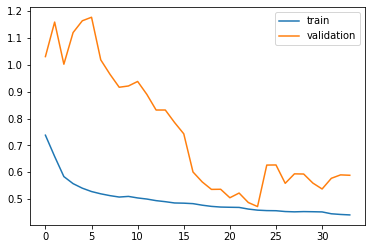


predict: [[31.88856072 22.01262201]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7407 - mean_squared_error: 0.8659 - val_loss: 0.8606 - val_mean_squared_error: 0.7633
Epoch 2/1000
 - 1s - loss: 0.6185 - mean_squared_error: 0.6306 - val_loss: 0.8194 - val_mean_squared_error: 0.6802
Epoch 3/1000
 - 1s - loss: 0.5709 - mean_squared_error: 0.5490 - val_loss: 0.7538 - val_mean_squared_error: 0.5733
Epoch 4/1000
 - 1s - loss: 0.5501 - mean_squared_error: 0.5193 - val_loss: 0.8501 - val_mean_squared_error: 0.7389
Epoch 5/1000
 - 1s - loss: 0.5413 - mean_squared_error: 0.5130 - val_loss: 0.8741 - val_mean_squared_error: 0.7848
Epoch 6/1000
 - 1s - loss: 0.5353 - mean_squared_error: 0.4982 - val_loss: 0.8911 - val_mean_squared_error: 0.8227
Epoch 7/1000
 - 1s - loss: 0.5289 - mean_squared_error: 0.4911 - val_loss: 0.9168 - val_mean_squared_error: 0.8784
Epoch 8/1000
 - 1s - loss: 0.5233 - mean_squared_error: 0.4813 - val_loss: 0.9363 - va

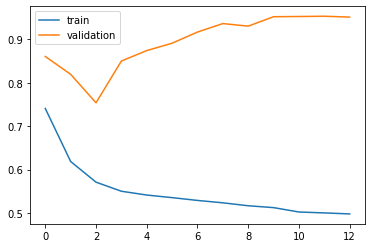


predict: [[31.62616281 22.51595704]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7553 - mean_squared_error: 0.8941 - val_loss: 0.8550 - val_mean_squared_error: 0.9181
Epoch 2/1000
 - 1s - loss: 0.6157 - mean_squared_error: 0.6400 - val_loss: 0.7052 - val_mean_squared_error: 0.6952
Epoch 3/1000
 - 1s - loss: 0.5676 - mean_squared_error: 0.5506 - val_loss: 0.7194 - val_mean_squared_error: 0.6935
Epoch 4/1000
 - 1s - loss: 0.5572 - mean_squared_error: 0.5307 - val_loss: 0.7166 - val_mean_squared_error: 0.7190
Epoch 5/1000
 - 1s - loss: 0.5444 - mean_squared_error: 0.5170 - val_loss: 0.7484 - val_mean_squared_error: 0.7546
Epoch 6/1000
 - 1s - loss: 0.5368 - mean_squared_error: 0.5053 - val_loss: 0.7455 - val_mean_squared_error: 0.8024
Epoch 7/1000
 - 1s - loss: 0.5304 - mean_squared_error: 0.4922 - val_loss: 0.7962 - val_mean_squared_error: 0.8683
Epoch 8/1000
 - 1s - loss: 0.5282 - mean_squared_error: 0.4898 - val_loss: 0.7312 - va

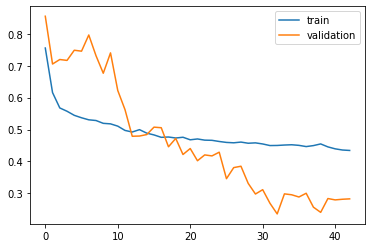


predict: [[31.616079   22.48339875]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7256 - mean_squared_error: 0.8407 - val_loss: 0.7777 - val_mean_squared_error: 1.1341
Epoch 2/1000
 - 1s - loss: 0.6096 - mean_squared_error: 0.6180 - val_loss: 0.6525 - val_mean_squared_error: 0.6881
Epoch 3/1000
 - 1s - loss: 0.5646 - mean_squared_error: 0.5391 - val_loss: 0.6552 - val_mean_squared_error: 0.5780
Epoch 4/1000
 - 1s - loss: 0.5493 - mean_squared_error: 0.5190 - val_loss: 0.7475 - val_mean_squared_error: 0.8029
Epoch 5/1000
 - 1s - loss: 0.5443 - mean_squared_error: 0.5147 - val_loss: 0.6679 - val_mean_squared_error: 0.6784
Epoch 6/1000
 - 1s - loss: 0.5364 - mean_squared_error: 0.5020 - val_loss: 0.7168 - val_mean_squared_error: 0.7249
Epoch 7/1000
 - 1s - loss: 0.5303 - mean_squared_error: 0.4955 - val_loss: 0.7256 - val_mean_squared_error: 0.7321
Epoch 8/1000
 - 1s - loss: 0.5253 - mean_squared_error: 0.4862 - val_loss: 0.6998 - va

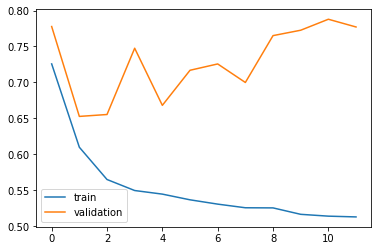


predict: [[32.16840044 22.60972343]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7449 - mean_squared_error: 0.8699 - val_loss: 0.4181 - val_mean_squared_error: 0.3260
Epoch 2/1000
 - 1s - loss: 0.6521 - mean_squared_error: 0.6829 - val_loss: 0.4378 - val_mean_squared_error: 0.3487
Epoch 3/1000
 - 1s - loss: 0.5899 - mean_squared_error: 0.5791 - val_loss: 0.4409 - val_mean_squared_error: 0.3522
Epoch 4/1000
 - 1s - loss: 0.5616 - mean_squared_error: 0.5373 - val_loss: 0.4379 - val_mean_squared_error: 0.3258
Epoch 5/1000
 - 1s - loss: 0.5459 - mean_squared_error: 0.5135 - val_loss: 0.5313 - val_mean_squared_error: 0.4421
Epoch 6/1000
 - 1s - loss: 0.5382 - mean_squared_error: 0.5085 - val_loss: 0.4554 - val_mean_squared_error: 0.3386
Epoch 7/1000
 - 1s - loss: 0.5311 - mean_squared_error: 0.4936 - val_loss: 0.4699 - val_mean_squared_error: 0.3831
Epoch 8/1000
 - 1s - loss: 0.5270 - mean_squared_error: 0.4905 - val_loss: 0.4463 - va

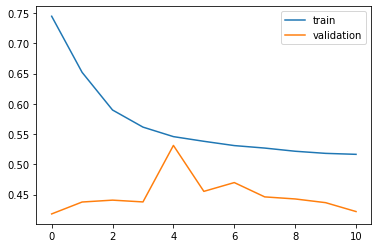


predict: [[32.2703375  22.93008421]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7726 - mean_squared_error: 0.9298 - val_loss: 0.6639 - val_mean_squared_error: 0.5482
Epoch 2/1000
 - 1s - loss: 0.6647 - mean_squared_error: 0.7239 - val_loss: 0.5224 - val_mean_squared_error: 0.3614
Epoch 3/1000
 - 1s - loss: 0.5729 - mean_squared_error: 0.5544 - val_loss: 0.5369 - val_mean_squared_error: 0.3645
Epoch 4/1000
 - 1s - loss: 0.5554 - mean_squared_error: 0.5291 - val_loss: 0.5900 - val_mean_squared_error: 0.4334
Epoch 5/1000
 - 1s - loss: 0.5451 - mean_squared_error: 0.5223 - val_loss: 0.5679 - val_mean_squared_error: 0.4458
Epoch 6/1000
 - 1s - loss: 0.5402 - mean_squared_error: 0.5096 - val_loss: 0.5940 - val_mean_squared_error: 0.4525
Epoch 7/1000
 - 1s - loss: 0.5348 - mean_squared_error: 0.4995 - val_loss: 0.5913 - val_mean_squared_error: 0.4608
Epoch 8/1000
 - 1s - loss: 0.5279 - mean_squared_error: 0.4898 - val_loss: 0.6103 - va

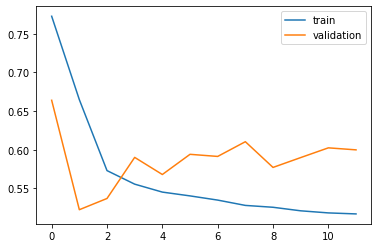


predict: [[31.93437684 22.65849445]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7212 - mean_squared_error: 0.8249 - val_loss: 0.4525 - val_mean_squared_error: 0.3680
Epoch 2/1000
 - 1s - loss: 0.6161 - mean_squared_error: 0.6475 - val_loss: 0.5149 - val_mean_squared_error: 0.4483
Epoch 3/1000
 - 1s - loss: 0.5765 - mean_squared_error: 0.5860 - val_loss: 0.5179 - val_mean_squared_error: 0.4112
Epoch 4/1000
 - 1s - loss: 0.5556 - mean_squared_error: 0.5363 - val_loss: 0.5634 - val_mean_squared_error: 0.5647
Epoch 5/1000
 - 1s - loss: 0.5425 - mean_squared_error: 0.5148 - val_loss: 0.5176 - val_mean_squared_error: 0.4721
Epoch 6/1000
 - 1s - loss: 0.5353 - mean_squared_error: 0.5033 - val_loss: 0.6510 - val_mean_squared_error: 0.7353
Epoch 7/1000
 - 1s - loss: 0.5318 - mean_squared_error: 0.5008 - val_loss: 0.6873 - val_mean_squared_error: 0.7569
Epoch 8/1000
 - 1s - loss: 0.5251 - mean_squared_error: 0.4892 - val_loss: 0.7415 - va

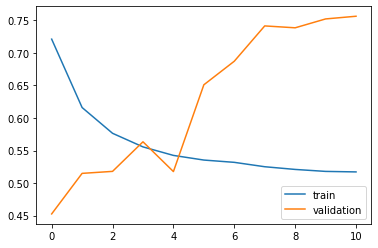


predict: [[31.9963944  22.79923041]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7277 - mean_squared_error: 0.8378 - val_loss: 0.7715 - val_mean_squared_error: 0.5984
Epoch 2/1000
 - 1s - loss: 0.6376 - mean_squared_error: 0.6822 - val_loss: 0.7774 - val_mean_squared_error: 0.6050
Epoch 3/1000
 - 1s - loss: 0.5853 - mean_squared_error: 0.5962 - val_loss: 0.6918 - val_mean_squared_error: 0.4795
Epoch 4/1000
 - 1s - loss: 0.5616 - mean_squared_error: 0.5555 - val_loss: 0.8201 - val_mean_squared_error: 0.6757
Epoch 5/1000
 - 1s - loss: 0.5485 - mean_squared_error: 0.5419 - val_loss: 0.7211 - val_mean_squared_error: 0.5226
Epoch 6/1000
 - 1s - loss: 0.5365 - mean_squared_error: 0.5033 - val_loss: 0.7923 - val_mean_squared_error: 0.6558
Epoch 7/1000
 - 1s - loss: 0.5360 - mean_squared_error: 0.5074 - val_loss: 0.7399 - val_mean_squared_error: 0.5566
Epoch 8/1000
 - 1s - loss: 0.5302 - mean_squared_error: 0.4894 - val_loss: 0.7801 - va

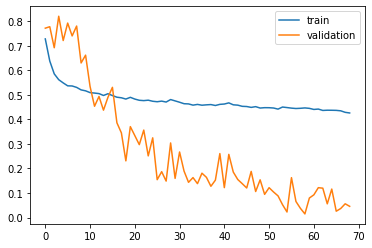


predict: [[30.81234548 21.93150564]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7380 - mean_squared_error: 0.8489 - val_loss: 1.1376 - val_mean_squared_error: 2.3457
Epoch 2/1000
 - 1s - loss: 0.6417 - mean_squared_error: 0.6835 - val_loss: 1.1256 - val_mean_squared_error: 2.3366
Epoch 3/1000
 - 1s - loss: 0.5777 - mean_squared_error: 0.5730 - val_loss: 1.1494 - val_mean_squared_error: 2.4130
Epoch 4/1000
 - 1s - loss: 0.5541 - mean_squared_error: 0.5361 - val_loss: 1.1683 - val_mean_squared_error: 2.6347
Epoch 5/1000
 - 1s - loss: 0.5462 - mean_squared_error: 0.5217 - val_loss: 1.1669 - val_mean_squared_error: 2.4191
Epoch 6/1000
 - 1s - loss: 0.5352 - mean_squared_error: 0.5083 - val_loss: 1.1327 - val_mean_squared_error: 2.1683
Epoch 7/1000
 - 1s - loss: 0.5324 - mean_squared_error: 0.5014 - val_loss: 1.1922 - val_mean_squared_error: 2.3317
Epoch 8/1000
 - 1s - loss: 0.5307 - mean_squared_error: 0.4974 - val_loss: 1.1309 - va

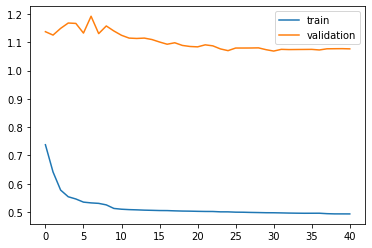


predict: [[32.81356854 22.86853258]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6648 - mean_squared_error: 0.7262 - val_loss: 0.8903 - val_mean_squared_error: 1.1682
Epoch 2/1000
 - 1s - loss: 0.5909 - mean_squared_error: 0.5943 - val_loss: 0.7996 - val_mean_squared_error: 1.0647
Epoch 3/1000
 - 1s - loss: 0.5620 - mean_squared_error: 0.5503 - val_loss: 0.7801 - val_mean_squared_error: 1.1339
Epoch 4/1000
 - 1s - loss: 0.5444 - mean_squared_error: 0.5247 - val_loss: 0.8404 - val_mean_squared_error: 1.2464
Epoch 5/1000
 - 1s - loss: 0.5339 - mean_squared_error: 0.5060 - val_loss: 0.8455 - val_mean_squared_error: 1.2040
Epoch 6/1000
 - 1s - loss: 0.5244 - mean_squared_error: 0.4909 - val_loss: 0.7999 - val_mean_squared_error: 1.0241
Epoch 7/1000
 - 1s - loss: 0.5207 - mean_squared_error: 0.4841 - val_loss: 0.8184 - val_mean_squared_error: 1.1601
Epoch 8/1000
 - 1s - loss: 0.5242 - mean_squared_error: 0.5019 - val_loss: 0.8248 - va

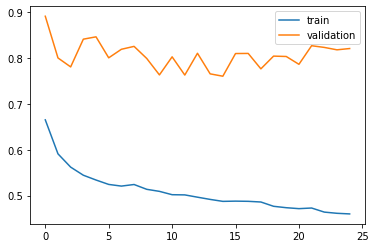


predict: [[32.32682207 22.59737571]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7414 - mean_squared_error: 0.8459 - val_loss: 0.8566 - val_mean_squared_error: 0.7359
Epoch 2/1000
 - 1s - loss: 0.6346 - mean_squared_error: 0.6553 - val_loss: 0.8742 - val_mean_squared_error: 0.7667
Epoch 3/1000
 - 1s - loss: 0.5823 - mean_squared_error: 0.5713 - val_loss: 0.8736 - val_mean_squared_error: 0.7667
Epoch 4/1000
 - 1s - loss: 0.5595 - mean_squared_error: 0.5444 - val_loss: 0.8391 - val_mean_squared_error: 0.7077
Epoch 5/1000
 - 1s - loss: 0.5421 - mean_squared_error: 0.5209 - val_loss: 0.8627 - val_mean_squared_error: 0.7719
Epoch 6/1000
 - 1s - loss: 0.5301 - mean_squared_error: 0.5000 - val_loss: 0.8708 - val_mean_squared_error: 0.7850
Epoch 7/1000
 - 1s - loss: 0.5244 - mean_squared_error: 0.4878 - val_loss: 0.8061 - val_mean_squared_error: 0.6840
Epoch 8/1000
 - 1s - loss: 0.5217 - mean_squared_error: 0.4858 - val_loss: 0.8369 - va

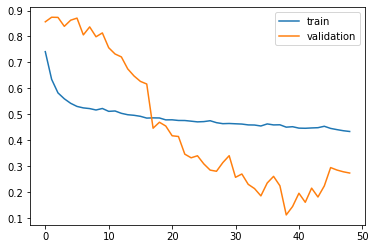


predict: [[32.40320538 22.4850215 ]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7406 - mean_squared_error: 0.8668 - val_loss: 1.1439 - val_mean_squared_error: 1.3848
Epoch 2/1000
 - 1s - loss: 0.6224 - mean_squared_error: 0.6526 - val_loss: 0.9960 - val_mean_squared_error: 1.1077
Epoch 3/1000
 - 1s - loss: 0.5792 - mean_squared_error: 0.5740 - val_loss: 0.9127 - val_mean_squared_error: 0.9522
Epoch 4/1000
 - 1s - loss: 0.5477 - mean_squared_error: 0.5230 - val_loss: 0.9362 - val_mean_squared_error: 1.0672
Epoch 5/1000
 - 1s - loss: 0.5364 - mean_squared_error: 0.5058 - val_loss: 0.9609 - val_mean_squared_error: 0.9864
Epoch 6/1000
 - 1s - loss: 0.5331 - mean_squared_error: 0.5074 - val_loss: 0.9335 - val_mean_squared_error: 0.9001
Epoch 7/1000
 - 1s - loss: 0.5275 - mean_squared_error: 0.4871 - val_loss: 0.9622 - val_mean_squared_error: 0.9775
Epoch 8/1000
 - 1s - loss: 0.5210 - mean_squared_error: 0.4769 - val_loss: 0.9258 - va

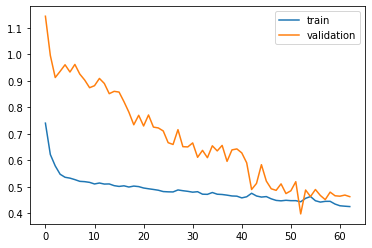


predict: [[32.03593185 21.79802895]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7595 - mean_squared_error: 0.9123 - val_loss: 2.3757 - val_mean_squared_error: 6.8257
Epoch 2/1000
 - 1s - loss: 0.6426 - mean_squared_error: 0.6893 - val_loss: 2.2951 - val_mean_squared_error: 6.2949
Epoch 3/1000
 - 1s - loss: 0.5852 - mean_squared_error: 0.5793 - val_loss: 2.1110 - val_mean_squared_error: 5.2502
Epoch 4/1000
 - 1s - loss: 0.5554 - mean_squared_error: 0.5297 - val_loss: 2.1244 - val_mean_squared_error: 5.2554
Epoch 5/1000
 - 1s - loss: 0.5429 - mean_squared_error: 0.5151 - val_loss: 2.0927 - val_mean_squared_error: 5.2868
Epoch 6/1000
 - 1s - loss: 0.5395 - mean_squared_error: 0.5246 - val_loss: 2.0344 - val_mean_squared_error: 5.0502
Epoch 7/1000
 - 1s - loss: 0.5298 - mean_squared_error: 0.4983 - val_loss: 2.0788 - val_mean_squared_error: 5.2727
Epoch 8/1000
 - 1s - loss: 0.5212 - mean_squared_error: 0.4820 - val_loss: 2.0928 - va

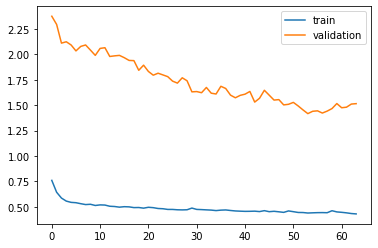


predict: [[31.46863812 22.32871562]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7077 - mean_squared_error: 0.7944 - val_loss: 1.5157 - val_mean_squared_error: 2.3526
Epoch 2/1000
 - 0s - loss: 0.6189 - mean_squared_error: 0.6450 - val_loss: 1.5600 - val_mean_squared_error: 2.4758
Epoch 3/1000
 - 0s - loss: 0.5897 - mean_squared_error: 0.5904 - val_loss: 1.5125 - val_mean_squared_error: 2.3213
Epoch 4/1000
 - 0s - loss: 0.5615 - mean_squared_error: 0.5452 - val_loss: 1.5092 - val_mean_squared_error: 2.3149
Epoch 5/1000
 - 0s - loss: 0.5403 - mean_squared_error: 0.5098 - val_loss: 1.4702 - val_mean_squared_error: 2.1950
Epoch 6/1000
 - 0s - loss: 0.5282 - mean_squared_error: 0.4916 - val_loss: 1.4605 - val_mean_squared_error: 2.1706
Epoch 7/1000
 - 1s - loss: 0.5217 - mean_squared_error: 0.4781 - val_loss: 1.3820 - val_mean_squared_error: 1.9348
Epoch 8/1000
 - 0s - loss: 0.5166 - mean_squared_error: 0.4687 - val_loss: 1.4010 - va

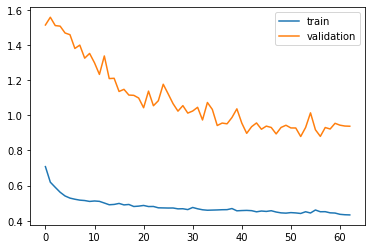


predict: [[31.64875423 22.38341886]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7579 - mean_squared_error: 0.8899 - val_loss: 0.8993 - val_mean_squared_error: 0.8115
Epoch 2/1000
 - 0s - loss: 0.6595 - mean_squared_error: 0.7044 - val_loss: 0.7343 - val_mean_squared_error: 0.5398
Epoch 3/1000
 - 0s - loss: 0.6181 - mean_squared_error: 0.6363 - val_loss: 0.6794 - val_mean_squared_error: 0.4630
Epoch 4/1000
 - 0s - loss: 0.5824 - mean_squared_error: 0.5689 - val_loss: 0.6939 - val_mean_squared_error: 0.4816
Epoch 5/1000
 - 0s - loss: 0.5535 - mean_squared_error: 0.5252 - val_loss: 0.7075 - val_mean_squared_error: 0.5022
Epoch 6/1000
 - 0s - loss: 0.5365 - mean_squared_error: 0.5012 - val_loss: 0.6967 - val_mean_squared_error: 0.4855
Epoch 7/1000
 - 0s - loss: 0.5307 - mean_squared_error: 0.4951 - val_loss: 0.7060 - val_mean_squared_error: 0.5041
Epoch 8/1000
 - 0s - loss: 0.5221 - mean_squared_error: 0.4778 - val_loss: 0.6959 - va

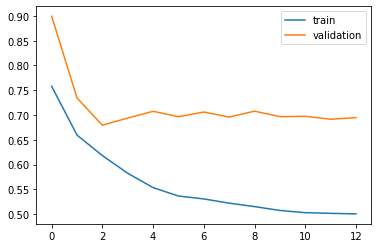


predict: [[32.07972185 22.38399407]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7423 - mean_squared_error: 0.8815 - val_loss: 1.1605 - val_mean_squared_error: 2.3215
Epoch 2/1000
 - 0s - loss: 0.6273 - mean_squared_error: 0.6526 - val_loss: 0.9845 - val_mean_squared_error: 1.8795
Epoch 3/1000
 - 0s - loss: 0.5868 - mean_squared_error: 0.5690 - val_loss: 0.9095 - val_mean_squared_error: 1.5008
Epoch 4/1000
 - 0s - loss: 0.5588 - mean_squared_error: 0.5232 - val_loss: 0.9059 - val_mean_squared_error: 1.5709
Epoch 5/1000
 - 0s - loss: 0.5422 - mean_squared_error: 0.4998 - val_loss: 0.9681 - val_mean_squared_error: 1.6129
Epoch 6/1000
 - 0s - loss: 0.5338 - mean_squared_error: 0.4894 - val_loss: 0.9821 - val_mean_squared_error: 1.4713
Epoch 7/1000
 - 0s - loss: 0.5282 - mean_squared_error: 0.4857 - val_loss: 1.0108 - val_mean_squared_error: 1.4670
Epoch 8/1000
 - 0s - loss: 0.5295 - mean_squared_error: 0.4826 - val_loss: 1.0497 - va

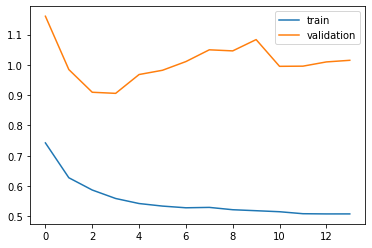


predict: [[31.9339261  22.74029064]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7513 - mean_squared_error: 0.8631 - val_loss: 0.4952 - val_mean_squared_error: 0.2837
Epoch 2/1000
 - 0s - loss: 0.6702 - mean_squared_error: 0.7013 - val_loss: 0.6408 - val_mean_squared_error: 0.4266
Epoch 3/1000
 - 0s - loss: 0.6029 - mean_squared_error: 0.6019 - val_loss: 0.5136 - val_mean_squared_error: 0.2886
Epoch 4/1000
 - 0s - loss: 0.5652 - mean_squared_error: 0.5360 - val_loss: 0.4984 - val_mean_squared_error: 0.2731
Epoch 5/1000
 - 0s - loss: 0.5482 - mean_squared_error: 0.5146 - val_loss: 0.4875 - val_mean_squared_error: 0.2727
Epoch 6/1000
 - 0s - loss: 0.5342 - mean_squared_error: 0.4983 - val_loss: 0.5146 - val_mean_squared_error: 0.2897
Epoch 7/1000
 - 0s - loss: 0.5260 - mean_squared_error: 0.4905 - val_loss: 0.4536 - val_mean_squared_error: 0.2352
Epoch 8/1000
 - 0s - loss: 0.5202 - mean_squared_error: 0.4738 - val_loss: 0.4968 - va

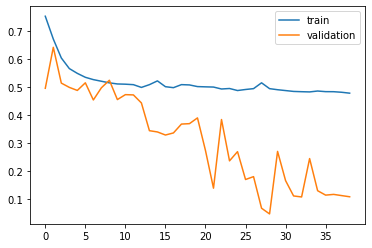


predict: [[32.11302087 22.32201189]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7363 - mean_squared_error: 0.8532 - val_loss: 0.8491 - val_mean_squared_error: 0.7702
Epoch 2/1000
 - 0s - loss: 0.6367 - mean_squared_error: 0.6560 - val_loss: 0.7143 - val_mean_squared_error: 0.5237
Epoch 3/1000
 - 0s - loss: 0.5855 - mean_squared_error: 0.5694 - val_loss: 0.4699 - val_mean_squared_error: 0.2355
Epoch 4/1000
 - 0s - loss: 0.5472 - mean_squared_error: 0.5100 - val_loss: 0.4346 - val_mean_squared_error: 0.2033
Epoch 5/1000
 - 0s - loss: 0.5371 - mean_squared_error: 0.4946 - val_loss: 0.4806 - val_mean_squared_error: 0.2439
Epoch 6/1000
 - 0s - loss: 0.5226 - mean_squared_error: 0.4802 - val_loss: 0.4725 - val_mean_squared_error: 0.2457
Epoch 7/1000
 - 0s - loss: 0.5129 - mean_squared_error: 0.4644 - val_loss: 0.4456 - val_mean_squared_error: 0.2091
Epoch 8/1000
 - 0s - loss: 0.5048 - mean_squared_error: 0.4563 - val_loss: 0.4358 - va

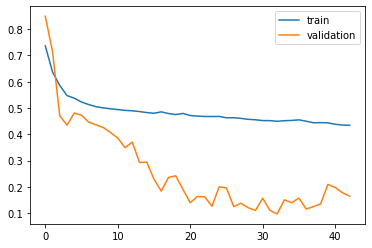


predict: [[31.88416933 22.63791096]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7276 - mean_squared_error: 0.8143 - val_loss: 0.5713 - val_mean_squared_error: 0.4336
Epoch 2/1000
 - 0s - loss: 0.6318 - mean_squared_error: 0.6388 - val_loss: 0.3673 - val_mean_squared_error: 0.2109
Epoch 3/1000
 - 0s - loss: 0.5653 - mean_squared_error: 0.5352 - val_loss: 0.3287 - val_mean_squared_error: 0.1908
Epoch 4/1000
 - 0s - loss: 0.5435 - mean_squared_error: 0.5039 - val_loss: 0.3190 - val_mean_squared_error: 0.1727
Epoch 5/1000
 - 0s - loss: 0.5354 - mean_squared_error: 0.4972 - val_loss: 0.4737 - val_mean_squared_error: 0.2754
Epoch 6/1000
 - 0s - loss: 0.5277 - mean_squared_error: 0.4867 - val_loss: 0.3628 - val_mean_squared_error: 0.2157
Epoch 7/1000
 - 0s - loss: 0.5261 - mean_squared_error: 0.4832 - val_loss: 0.4489 - val_mean_squared_error: 0.2726
Epoch 8/1000
 - 0s - loss: 0.5218 - mean_squared_error: 0.4761 - val_loss: 0.4413 - va

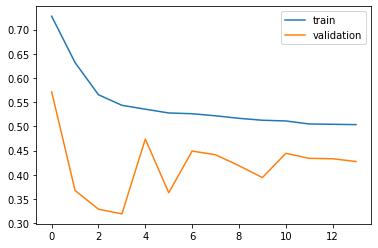


predict: [[31.71788805 22.69244793]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7441 - mean_squared_error: 0.8803 - val_loss: 0.3217 - val_mean_squared_error: 0.2060
Epoch 2/1000
 - 0s - loss: 0.6150 - mean_squared_error: 0.6353 - val_loss: 0.2067 - val_mean_squared_error: 0.0658
Epoch 3/1000
 - 0s - loss: 0.5645 - mean_squared_error: 0.5441 - val_loss: 0.3361 - val_mean_squared_error: 0.1194
Epoch 4/1000
 - 0s - loss: 0.5396 - mean_squared_error: 0.5028 - val_loss: 0.2900 - val_mean_squared_error: 0.1077
Epoch 5/1000
 - 0s - loss: 0.5269 - mean_squared_error: 0.4849 - val_loss: 0.3119 - val_mean_squared_error: 0.1190
Epoch 6/1000
 - 0s - loss: 0.5202 - mean_squared_error: 0.4764 - val_loss: 0.3103 - val_mean_squared_error: 0.1120
Epoch 7/1000
 - 0s - loss: 0.5129 - mean_squared_error: 0.4669 - val_loss: 0.2877 - val_mean_squared_error: 0.0976
Epoch 8/1000
 - 0s - loss: 0.5060 - mean_squared_error: 0.4610 - val_loss: 0.3017 - va

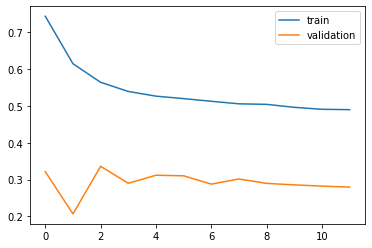


predict: [[31.57941034 22.58035081]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7472 - mean_squared_error: 0.8569 - val_loss: 0.4598 - val_mean_squared_error: 0.3568
Epoch 2/1000
 - 0s - loss: 0.6712 - mean_squared_error: 0.7063 - val_loss: 0.3974 - val_mean_squared_error: 0.3011
Epoch 3/1000
 - 0s - loss: 0.5954 - mean_squared_error: 0.5801 - val_loss: 0.4059 - val_mean_squared_error: 0.3225
Epoch 4/1000
 - 0s - loss: 0.5444 - mean_squared_error: 0.5046 - val_loss: 0.3250 - val_mean_squared_error: 0.1925
Epoch 5/1000
 - 0s - loss: 0.5267 - mean_squared_error: 0.4807 - val_loss: 0.3418 - val_mean_squared_error: 0.2234
Epoch 6/1000
 - 0s - loss: 0.5170 - mean_squared_error: 0.4680 - val_loss: 0.3236 - val_mean_squared_error: 0.1988
Epoch 7/1000
 - 0s - loss: 0.5088 - mean_squared_error: 0.4602 - val_loss: 0.3438 - val_mean_squared_error: 0.2176
Epoch 8/1000
 - 0s - loss: 0.5045 - mean_squared_error: 0.4605 - val_loss: 0.3309 - va

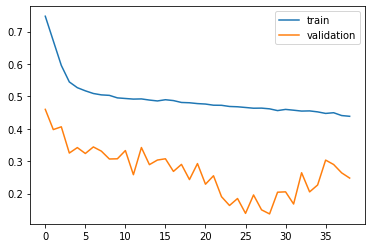


predict: [[31.62225303 22.6317583 ]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7723 - mean_squared_error: 0.9320 - val_loss: 0.3265 - val_mean_squared_error: 0.1235
Epoch 2/1000
 - 0s - loss: 0.6989 - mean_squared_error: 0.7601 - val_loss: 0.3901 - val_mean_squared_error: 0.1816
Epoch 3/1000
 - 0s - loss: 0.6385 - mean_squared_error: 0.6517 - val_loss: 0.3614 - val_mean_squared_error: 0.1719
Epoch 4/1000
 - 0s - loss: 0.5691 - mean_squared_error: 0.5399 - val_loss: 0.3655 - val_mean_squared_error: 0.1442
Epoch 5/1000
 - 0s - loss: 0.5337 - mean_squared_error: 0.4949 - val_loss: 0.4197 - val_mean_squared_error: 0.1833
Epoch 6/1000
 - 0s - loss: 0.5229 - mean_squared_error: 0.4822 - val_loss: 0.3944 - val_mean_squared_error: 0.1696
Epoch 7/1000
 - 0s - loss: 0.5185 - mean_squared_error: 0.4715 - val_loss: 0.4075 - val_mean_squared_error: 0.1703
Epoch 8/1000
 - 0s - loss: 0.5121 - mean_squared_error: 0.4695 - val_loss: 0.4109 - va

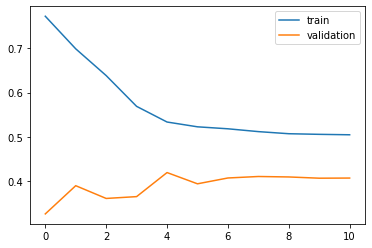


predict: [[31.72332043 22.96681564]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7517 - mean_squared_error: 0.8673 - val_loss: 1.2808 - val_mean_squared_error: 1.6887
Epoch 2/1000
 - 0s - loss: 0.6256 - mean_squared_error: 0.6431 - val_loss: 1.2168 - val_mean_squared_error: 1.6575
Epoch 3/1000
 - 0s - loss: 0.5773 - mean_squared_error: 0.5591 - val_loss: 1.1133 - val_mean_squared_error: 1.4383
Epoch 4/1000
 - 0s - loss: 0.5447 - mean_squared_error: 0.5086 - val_loss: 1.0017 - val_mean_squared_error: 1.1584
Epoch 5/1000
 - 0s - loss: 0.5336 - mean_squared_error: 0.4926 - val_loss: 0.8941 - val_mean_squared_error: 0.9516
Epoch 6/1000
 - 0s - loss: 0.5236 - mean_squared_error: 0.4788 - val_loss: 0.9155 - val_mean_squared_error: 0.9609
Epoch 7/1000
 - 0s - loss: 0.5196 - mean_squared_error: 0.4749 - val_loss: 0.8950 - val_mean_squared_error: 0.9118
Epoch 8/1000
 - 0s - loss: 0.5154 - mean_squared_error: 0.4686 - val_loss: 0.9026 - va

 - 0s - loss: 0.4485 - mean_squared_error: 0.3867 - val_loss: 0.5860 - val_mean_squared_error: 0.6826
Epoch 71/1000
 - 0s - loss: 0.4483 - mean_squared_error: 0.3865 - val_loss: 0.5859 - val_mean_squared_error: 0.6804
Epoch 72/1000
 - 0s - loss: 0.4483 - mean_squared_error: 0.3863 - val_loss: 0.5895 - val_mean_squared_error: 0.6817
Epoch 73/1000
 - 0s - loss: 0.4478 - mean_squared_error: 0.3855 - val_loss: 0.5908 - val_mean_squared_error: 0.6822
Epoch 74/1000
 - 0s - loss: 0.4476 - mean_squared_error: 0.3859 - val_loss: 0.5949 - val_mean_squared_error: 0.6819
Epoch 75/1000
 - 0s - loss: 0.4474 - mean_squared_error: 0.3850 - val_loss: 0.5952 - val_mean_squared_error: 0.6846

Epoch 00075: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 76/1000
 - 0s - loss: 0.4469 - mean_squared_error: 0.3845 - val_loss: 0.5953 - val_mean_squared_error: 0.6849
Epoch 77/1000
 - 0s - loss: 0.4469 - mean_squared_error: 0.3844 - val_loss: 0.5959 - val_mean_squared_error: 0.6853
Epoc

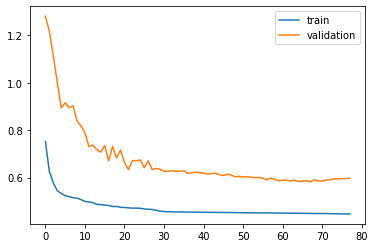


predict: [[31.97908903 22.68780944]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7279 - mean_squared_error: 0.8391 - val_loss: 0.8820 - val_mean_squared_error: 1.4476
Epoch 2/1000
 - 0s - loss: 0.6162 - mean_squared_error: 0.6280 - val_loss: 0.9785 - val_mean_squared_error: 1.6475
Epoch 3/1000
 - 0s - loss: 0.5820 - mean_squared_error: 0.5624 - val_loss: 0.8455 - val_mean_squared_error: 1.4196
Epoch 4/1000
 - 0s - loss: 0.5463 - mean_squared_error: 0.5150 - val_loss: 0.8369 - val_mean_squared_error: 1.3616
Epoch 5/1000
 - 0s - loss: 0.5346 - mean_squared_error: 0.4963 - val_loss: 0.9095 - val_mean_squared_error: 1.6081
Epoch 6/1000
 - 0s - loss: 0.5236 - mean_squared_error: 0.4860 - val_loss: 0.8519 - val_mean_squared_error: 1.3874
Epoch 7/1000
 - 0s - loss: 0.5227 - mean_squared_error: 0.4833 - val_loss: 0.8715 - val_mean_squared_error: 1.4330
Epoch 8/1000
 - 0s - loss: 0.5160 - mean_squared_error: 0.4730 - val_loss: 0.8759 - va

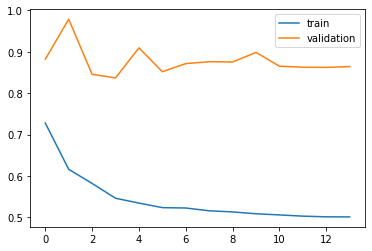


predict: [[31.70664433 22.63477701]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7134 - mean_squared_error: 0.8030 - val_loss: 0.6616 - val_mean_squared_error: 0.7357
Epoch 2/1000
 - 0s - loss: 0.6118 - mean_squared_error: 0.6060 - val_loss: 0.5491 - val_mean_squared_error: 0.5691
Epoch 3/1000
 - 0s - loss: 0.5603 - mean_squared_error: 0.5271 - val_loss: 0.5421 - val_mean_squared_error: 0.4758
Epoch 4/1000
 - 0s - loss: 0.5375 - mean_squared_error: 0.4999 - val_loss: 0.5510 - val_mean_squared_error: 0.5928
Epoch 5/1000
 - 0s - loss: 0.5288 - mean_squared_error: 0.4920 - val_loss: 0.5414 - val_mean_squared_error: 0.5426
Epoch 6/1000
 - 0s - loss: 0.5236 - mean_squared_error: 0.4839 - val_loss: 0.5486 - val_mean_squared_error: 0.5113
Epoch 7/1000
 - 0s - loss: 0.5196 - mean_squared_error: 0.4826 - val_loss: 0.5455 - val_mean_squared_error: 0.5088
Epoch 8/1000
 - 0s - loss: 0.5163 - mean_squared_error: 0.4738 - val_loss: 0.5440 - va

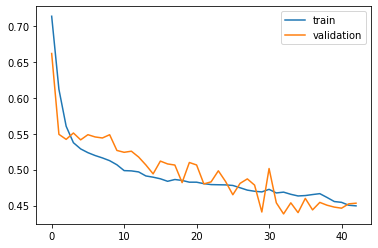


predict: [[32.37397516 23.06929726]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7609 - mean_squared_error: 0.8848 - val_loss: 0.8162 - val_mean_squared_error: 0.6671
Epoch 2/1000
 - 0s - loss: 0.6711 - mean_squared_error: 0.7138 - val_loss: 0.6638 - val_mean_squared_error: 0.4539
Epoch 3/1000
 - 0s - loss: 0.6007 - mean_squared_error: 0.5906 - val_loss: 0.6848 - val_mean_squared_error: 0.4690
Epoch 4/1000
 - 0s - loss: 0.5572 - mean_squared_error: 0.5288 - val_loss: 0.5076 - val_mean_squared_error: 0.2589
Epoch 5/1000
 - 0s - loss: 0.5339 - mean_squared_error: 0.5011 - val_loss: 0.6016 - val_mean_squared_error: 0.3668
Epoch 6/1000
 - 0s - loss: 0.5189 - mean_squared_error: 0.4814 - val_loss: 0.6329 - val_mean_squared_error: 0.4040
Epoch 7/1000
 - 0s - loss: 0.5131 - mean_squared_error: 0.4726 - val_loss: 0.6414 - val_mean_squared_error: 0.4201
Epoch 8/1000
 - 0s - loss: 0.5114 - mean_squared_error: 0.4758 - val_loss: 0.6300 - va

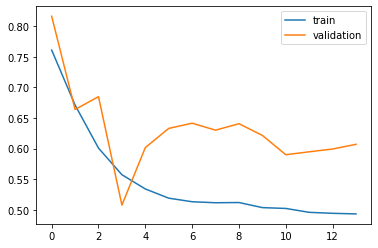


predict: [[31.51296358 22.32979116]]
real:      [[30.1 22.9]]

Train and validation time: 9.682118960221608



In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

standart_scaler = preprocessing.StandardScaler()
values_scaled = standart_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

inicio = time.time()
result = NCV(dataset_scaled, days_to_predict, standart_scaler)
fim = time.time()
print('Train and validation time: {}\n'.format((fim - inicio)/60))

In [13]:
y_hats = result[0]
y_tests = result[1]

metrics(y_hats, y_tests)

Maximum metrics
Test RMSE -------------------------- 2.152
Test VARIANCE ---------------------- -0.2173
Test MAX-ERROR --------------------- 5.749
Test MEAN-ABSOLUTE-ERROR ----------- 1.644
Test MEDIAN-ABSOLUTE-ERROR --------- 0.9113

Errors
30/04/2018 = 2.9076589370681347
29/04/2018 = 3.24031143120132
28/04/2018 = 0.8021332717229122
27/04/2018 = 0.2542086388149549
26/04/2018 = 0.8885607204477246
25/04/2018 = 0.926162812182767
24/04/2018 = 1.0160790037058405
23/04/2018 = 1.8684004369557918
22/04/2018 = 2.2703375045094916
21/04/2018 = 0.8343768370042604
20/04/2018 = 0.8963943972361541
19/04/2018 = 0.1876545188998726
18/04/2018 = 2.1135685434386
17/04/2018 = 4.426822065934246
16/04/2018 = 2.903205378388435
15/04/2018 = 1.3359318530282032
14/04/2018 = 0.16863811565193387
13/04/2018 = 5.748754231391516
12/04/2018 = 2.8797218537070925
11/04/2018 = 0.8339260990504727
10/04/2018 = 3.41302087171837
9/04/2018 = 0.6841693327699012
8/04/2018 = 0.6178880525937416
7/04/2018 = 0.5794103419819443
6/0